In [119]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Figures inline and set visualization style
%matplotlib inline
sns.set()

# Importing Data

In [120]:
df_train = pd.read_csv('data/train_trees.csv')
df_test = pd.read_csv('data/test_trees.csv')

# Exploring data

In [121]:
print(df_train.shape)

(15120, 56)


We can see that there are 15120 instances having 55 attributes


In [122]:
print(df_train.head(n=4))


   Id  Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
0   1       2596      51      3                               258   
1   2       2590      56      2                               212   
2   3       2804     139      9                               268   
3   4       2785     155     18                               242   

   Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
0                               0                              510   
1                              -6                              390   
2                              65                             3180   
3                             118                             3090   

   Hillshade_9am  Hillshade_Noon  Hillshade_3pm     ...      Soil_Type32  \
0            221             232            148     ...                0   
1            220             235            151     ...                0   
2            234             238            135     ...                0   

In [123]:
print(df_train.info())
print(df_train.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
Id                                    15120 non-null int64
Elevation                             15120 non-null int64
Aspect                                15120 non-null int64
Slope                                 15120 non-null int64
Horizontal_Distance_To_Hydrology      15120 non-null int64
Vertical_Distance_To_Hydrology        15120 non-null int64
Horizontal_Distance_To_Roadways       15120 non-null int64
Hillshade_9am                         15120 non-null int64
Hillshade_Noon                        15120 non-null int64
Hillshade_3pm                         15120 non-null int64
Horizontal_Distance_To_Fire_Points    15120 non-null int64
Wilderness_Area1                      15120 non-null int64
Wilderness_Area2                      15120 non-null int64
Wilderness_Area3                      15120 non-null int64
Wilderness_Area4                      15120 non-null int64
Soil_T

- No missing data, only int.
- Negative values present in Vertical_Distance_To_Hydrology. So, some tests such as chi-sq cant be used.
- Wilderness_Area and Soil_Type are one hot encoded. So, they could be converted back for some analysis.
- Attributes Soil_Type7 and Soil_Type15 can be removed as they are constant.
- Scales are not the same for all. So, rescaling and standardization may be necessary for some algos.

Drop the column Id, since it's just a serial number

In [127]:
df_train = df_train.iloc[:,1:]

## Skewness of the distribution

In [128]:
print(df_train.skew())

Aspect                                  0.450935
Slope                                   0.523658
Horizontal_Distance_To_Hydrology        1.488052
Vertical_Distance_To_Hydrology          1.537776
Horizontal_Distance_To_Roadways         1.247811
Hillshade_9am                          -1.093681
Hillshade_Noon                         -0.953232
Hillshade_3pm                          -0.340827
Horizontal_Distance_To_Fire_Points      1.617099
Wilderness_Area1                        1.231244
Wilderness_Area2                        5.228781
Wilderness_Area3                        0.324594
Wilderness_Area4                        0.825798
Soil_Type1                              6.294716
Soil_Type2                              4.617019
Soil_Type3                              3.575995
Soil_Type4                              3.872721
Soil_Type5                              9.416209
Soil_Type6                              4.506716
Soil_Type7                              0.000000
Soil_Type8          

Values close to 0 show less skew

Several attributes in Soil_Type show a large skew. So, some algos may benefit if skew is corrected

## Class distribution

In [129]:
df_train.groupby('Cover_Type').size()

Cover_Type
1    2160
2    2160
3    2160
4    2160
5    2160
6    2160
7    2160
dtype: int64

We see that all classes have an equal presence. No class re-balancing is necessary

## Correlation

Ignoring Wilderness_Area and Soil_Type as they are binary

In [130]:
data=df_train.iloc[:,:10] 
cols=data.columns

In [131]:
data_corr = data.corr()

# selecting only highly correlated attributes
threshold = 0.5

corr_list = []

#Searching for the highly correlated pairs
for i in range(0,10): 
    for j in range(i+1,10): #avoid repetition
        if (data_corr.iloc[i,j] >= threshold and data_corr.iloc[i,j] < 1) or (data_corr.iloc[i,j] < 0 and data_corr.iloc[i,j] <= -threshold):
            corr_list.append([data_corr.iloc[i,j],i,j]) 

#Sorting           
s_corr_list = sorted(corr_list,key=lambda x: -abs(x[0]))

#Printing
for v,i,j in s_corr_list:
    print ("%s and %s = %.2f" % (cols[i],cols[j],v))


Hillshade_9am and Hillshade_3pm = -0.78
Horizontal_Distance_To_Hydrology and Vertical_Distance_To_Hydrology = 0.65
Aspect and Hillshade_3pm = 0.64
Hillshade_Noon and Hillshade_3pm = 0.61
Slope and Hillshade_Noon = -0.61
Aspect and Hillshade_9am = -0.59


This represents an opportunity to reduce the feature set through transformations such as PCA

# Data Visualization

## Grouping of One hot encoded attributes

In [132]:
cols = df_train.columns
r,c = df_train.shape

data = pd.DataFrame(index=np.arange(0, r),columns=['Wilderness_Area','Soil_Type','Cover_Type'])

In [133]:
for i in range(0,r):
    w=0;
    s=0;
    # Category1 range
    for j in range(10,14):
        if (df_train.iloc[i,j] == 1):
            w=j-9  #category class
            break
    # Category2 range        
    for k in range(14,54):
        if (df_train.iloc[i,k] == 1):
            s=k-13 #category class
            break
    #Make an entry in 'data' for each r as category_id, target value        
    data.iloc[i]=[w,s,df_train.iloc[i,c-1]]

Plotting Wilderness Area

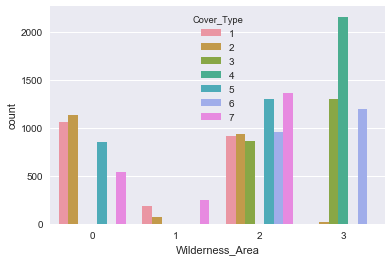

In [134]:
sns.countplot(x="Wilderness_Area", hue="Cover_Type", data=data)
plt.show()

- WildernessArea_4 has a lot of presence for cover_type 4. Good class distinction
- WildernessArea_3 has not much class distinction

Plotting Soil Type

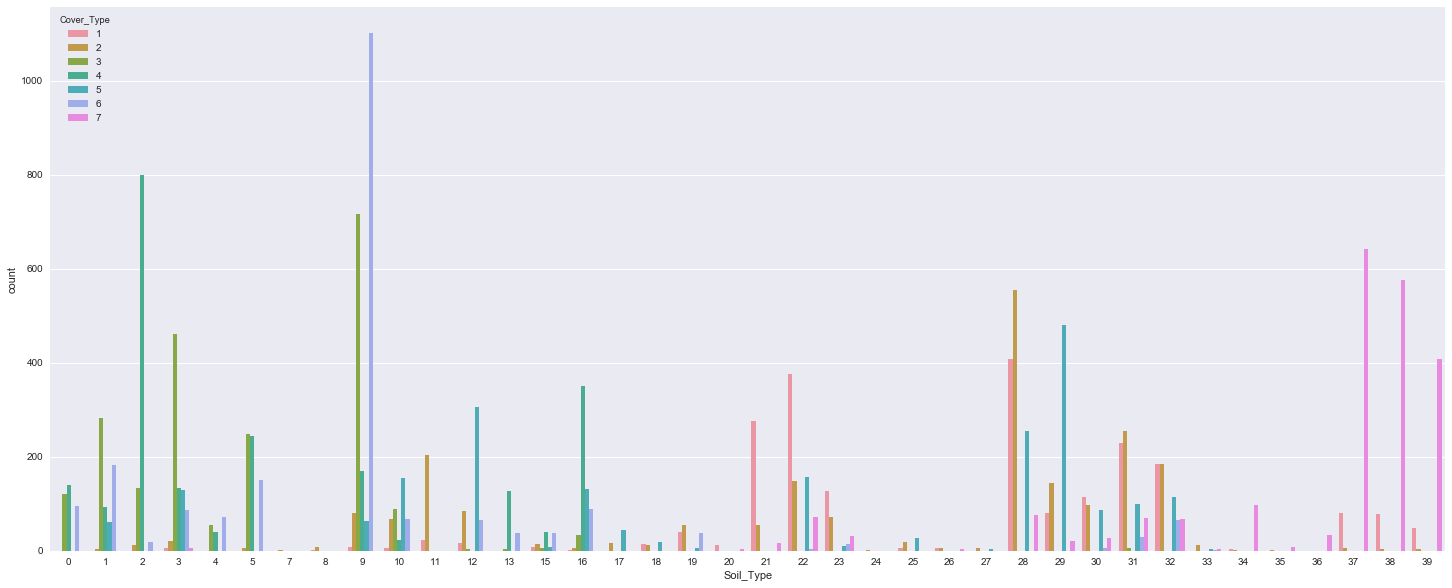

In [135]:
plt.rc("figure", figsize=(25, 10))
sns.countplot(x="Soil_Type", hue="Cover_Type", data=data)
plt.show()

Soil Type offers lot of class distinction as counts for some are very high

# Cleaning

 I'm going to remove constant columns

In [136]:
rem = []
for c in df_train.columns:
    if df_train[c].std() == 0: #standard deviation is zero
        rem.append(c)
       
#dropping the columns        
df_train.drop(rem,axis=1,inplace=True)

# Preparing data

Spliting data

In [137]:
array = df_train.values
X = array[:,:51]
y = array[:, 51]

from sklearn.model_selection import train_test_split

X_train, X_val, Y_train, Y_val = train_test_split(X, y, test_size=0.1, random_state=0)

# Creating the pipeline

In [149]:
# Import pipeline
from sklearn.pipeline import Pipeline

#Import libraries for data transformations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer

#Import the libraries
from sklearn.ensemble import RandomForestClassifier


pl = Pipeline([
        ('scale', StandardScaler()),
        ('scaler_2', MinMaxScaler()),
        ('Normalizer', Normalizer()),
        ('clf', ExtraTreesClassifier(n_estimators=15))
    ])

my_forest = pl.fit(X_train, Y_train)

Y_pred = my_forest.predict(df_test[['Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10', 'Soil_Type11',
       'Soil_Type12', 'Soil_Type13', 'Soil_Type14', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']])
df_test['Cover_Type'] = Y_pred
df_test[['Id', 'Cover_Type']].to_csv('data/ExtraTreesClassifier_Trees.csv', index=False)

C:\Users\zc2j\anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
